In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import molsysmt as msm
import numpy as np
from simtk import unit
import matplotlib.pyplot as plt

# RMSD, Least RMSD and Least RMSD fit

Lets load a small molecular system with a 5000 frames trajectory to show how MolSysMT gets the RMSD, the least RMSD, or the least RMSD fitted structures over a reference frame.

In [3]:
h5_file = msm.demo_systems.files['pentalanine.h5']
molecular_system = msm.convert(h5_file)

In [4]:
msm.info(molecular_system)

form,n_atoms,n_groups,n_components,n_chains,n_molecules,n_entities,n_peptides,n_frames
molsysmt.MolSys,62,7,1,1,1,1,1,5000


In [5]:
time = msm.get(molecular_system, target='system', time=True)

## RMSD

The root mean squared deviation of a set of atom coordinates $\vec{R}:(\vec{r_{1}}, \vec{r_{2}}, ..., \vec{r_{n}})$, with respect to a reference set of atom coordinates $\vec{R'}:(\vec{r'_{1}}, \vec{r'_{2}}, ..., \vec{r'_{n}})$, is defined as:

\begin{equation}
\text{RMSD} (\vec{R'},\vec{R}) = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} \Vert \vec{r'_{i}} - \vec{r_{i}} \Vert ^{2}}
\end{equation}

\begin{equation}
\text{RMSD} (\vec{R'},\vec{R}) = 
\sqrt{ \frac{1}{n} \sum_{i=1}^{n} [(x'-x)^2 + (z'-z)^2 + (z'-z)^2]}
\end{equation}

These two sets of atom coordinates, with the same number of atoms, could belong to structures of two different molecular systems or could also be structures of the same system. Let see the case where the RMSD is calculated only with the backbone atoms of the structure of our molecular system at frame 100-th taking the frame 0-th as reference:

In [6]:
rmsd = msm.rmsd(molecular_system, selection='backbone', frame_indices=100, reference_frame_index=0)

There object returned is a numpy array with a single RMSD value:

In [7]:
print(rmsd)

[0.73817043] nm


Lets get now the RMSD of every single frame in the trajectory with the same structure as reference, the one found in frame 0-th:

In [8]:
rmsd = msm.rmsd(molecular_system, selection='backbone', frame_indices='all', reference_frame_index=0)

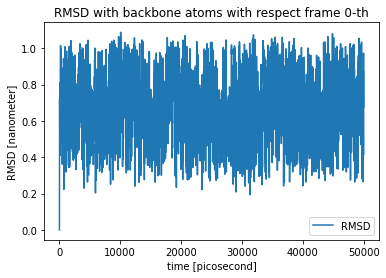

In [9]:
plt.plot(time, rmsd, label='RMSD')
plt.xlabel('time [{}]'.format(time.unit))
plt.ylabel('RMSD [{}]'.format(rmsd.unit))
plt.title('RMSD with backbone atoms with respect frame 0-th')
plt.legend()
plt.show()

In case of having two different molecular systems, `molsysmt.rmsd()` accepts all necessary input arguments to specify the set of atom coordinates to obtain the rmsd, for a single frame or a set of them: `item`, `selection` and `frame_indices` for the subject molecular system; and `reference_item`, `reference_selection`, and `reference_frame_index` for the reference molecular system.

Lets, for instance, create two different molecular systems (same topology in this case) to illustrate how these input arguments work:

In [10]:
molecular_system_1 = msm.extract(molecular_system, frame_indices=range(0,100))
molecular_system_2 = msm.extract(molecular_system, frame_indices=range(200,300))

In [11]:
rmsd = msm.rmsd(molecular_system_1, selection='backbone', frame_indices=80, 
                reference_item=molecular_system_2, reference_selection='backbone', reference_frame_index=20)

And we got the rmsd between to structures coming from two different frames from two molecular systems:

In [12]:
print(rmsd)

[0.94597531] nm


## Least RMSD

The RMSD value is not an observable that depends only on the internal geometry of a molecular system. A molecular system can have a frozen geometry but suffering translations or rotations relative to the reference the RMSD varies. Given this frozen geometry and the reference there exist a unique translation and rotation that, combined, minimizes the RMSD. If we want to use the RMSD as a metric to characterize how far two peptide or protein conformations are, the translation and rotation that makes the rmsd minimal needs to be found. Thereby, MolSysMT implements the algorithm proposed by Coutsias, Evangelos A., Chaok Seok, and Ken A. Dill in their work "Using quaternions to calculate RMSD" [[1](#Coutsias2004)] to obtained the least RMSD. The algorithm is implemented behind the method `molsysmt.least_rmsd()` with the same input arguments as `molsysmt.rmsd()`. Let's see the comparison of both methods when the observables are obtained for every frame of a trajectory with respect to the same reference:

In [13]:
lrmsd = msm.least_rmsd(molecular_system, selection='backbone', frame_indices='all', reference_frame_index=0)
rmsd = msm.rmsd(molecular_system, selection='backbone', frame_indices='all', reference_frame_index=0)

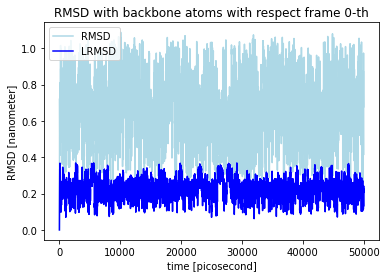

In [14]:
plt.plot(time, rmsd, color='lightblue', label='RMSD')
plt.plot(time, lrmsd, color='blue', label='LRMSD')
plt.xlabel('time [{}]'.format(time.unit))
plt.ylabel('RMSD [{}]'.format(rmsd.unit))
plt.title('RMSD with backbone atoms with respect frame 0-th')
plt.legend()
plt.show()

## Least RMSD fit

The same method to compute the least RMSD [[1](#Coutsias2004)] implemented in `molsysmt.rmsd()` provides with the translational and rotational operators that makes the RMSD minimal. This two operators, applied to the original structure, results with the best fitted structure over the reference one. MolSysMT includes a specific function to execute this least RMSD fitting: `molsysmt.least_rmsd_fit()`. All input arguments of `molsysmt.rmsd()` can be used with `molsysmt.least_rmsd_fit()`. Lets see a couple of examples:

In [15]:
fitted_molecular_system = msm.least_rmsd_fit(molecular_system, selection='backbone', frame_indices='all',
                                             reference_frame_index=0, to_form='molsysmt.MolSys')

Take heed to the input argument `to_form`, the above cell results with a new molecular system with the form specified by the former argument. Lets check the RMSD of the new frames over the frame 0-th. We can compare it with the result of `molsysmt.least_rmsd()`:

In [16]:
fitted_rmsd = msm.rmsd(fitted_molecular_system, selection='backbone', frame_indices='all', reference_frame_index=0)

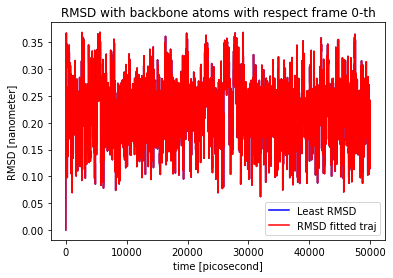

In [17]:
plt.plot(time, lrmsd, color='blue', label='Least RMSD')
plt.plot(time, fitted_rmsd, color='red', label='RMSD fitted traj')
plt.xlabel('time [{}]'.format(time.unit))
plt.ylabel('RMSD [{}]'.format(rmsd.unit))
plt.title('RMSD with backbone atoms with respect frame 0-th')
plt.legend()
plt.show()

In case of having the input argument `to_form=None`, the original molecular system is modified in place with the fitted frames. Lets, for instance, fit a segment of trajectory without producing a new molecular system:

In [18]:
msm.least_rmsd_fit(molecular_system, selection='backbone', frame_indices=range(2000,4000), reference_frame_index=0)

In [19]:
fitted_rmsd = msm.rmsd(molecular_system, selection='backbone', frame_indices='all', reference_frame_index=0)

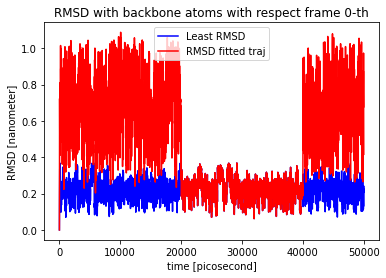

In [20]:
plt.plot(time, lrmsd, color='blue', label='Least RMSD')
plt.plot(time, fitted_rmsd, color='red', label='RMSD fitted traj')
plt.xlabel('time [{}]'.format(time.unit))
plt.ylabel('RMSD [{}]'.format(rmsd.unit))
plt.title('RMSD with backbone atoms with respect frame 0-th')
plt.legend()
plt.show()

------------

<a id='Coutsias2004'>[1]</a>  [Coutsias, Evangelos A., Chaok Seok, and Ken A. Dill. "Using quaternions to calculate RMSD." Journal of computational chemistry 25, no. 15 (2004): 1849-1857](https://doi.org/10.1002/jcc.20110)